In [2]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import EoN
import utils

# Base network

In [3]:
G = nx.barabasi_albert_graph(10**6, 5)

In [4]:
avg_deg = np.mean(list(G.degree), axis=0)[1]
rk_norm = EoN.get_PGFDPrime(EoN.get_Pk(G))(1)

pk = dict(sorted(EoN.get_Pk(G).items()))
qk = dict((k-1, k * p / avg_deg) for k, p in pk.items())
rk = dict((k-2, k*(k-1)*p / rk_norm) for k, p in pk.items())

In [5]:
ccdfs = list(map(utils.ccdf_from_pk, [pk, qk, rk]))

# Epidemic simulations

In [6]:
params = {'tmax': 100,  
          'tau': 0.1,    # transmission rate (for edges)
          'gamma': 1,  # recovery rate (for nodes)
          'rho': 0.0001,  # initial seed fraction
         }
print("Estimated R0: {:.2f}".format(
    EoN.estimate_R0(G, transmissibility = params['tau']/(params['tau']+params['gamma']))
))

Estimated R0: 3.69


In [7]:
sim_data = EoN.fast_SIR(G, return_full_data=True, **params)
T = sim_data.transmission_tree()

In [8]:
t = 1
infected = [x for x in utils.nodes_with_given_state_at_time(t, "I", sim_data, G.nodes()) 
                if x in T and list(T.predecessors(x))]

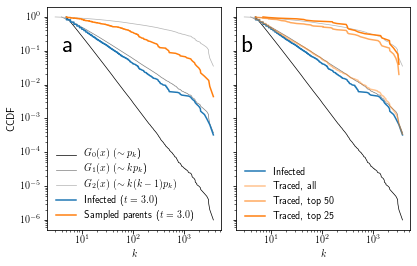

In [80]:
p_s = 0.1
p_t = 0.5
p_r = 0.5


np.random.shuffle(infected)
infected_sampled = infected[:int(len(infected)*p_s)]

parents = []
to_be_traced = Counter()
for node in infected_sampled:
    parent = list(T.predecessors(node))[0]
    parents.append(parent)
    temp = [x for x in G.neighbors(node) if x == parent or np.random.random() < p_t]
    for i in temp:
        if np.random.random() < p_r:
            to_be_traced[i] += 1


            
            
infected_ccdf = utils.ccdf_from_data(list(dict(G.degree(infected)).values()))
parents_ccdf = utils.ccdf_from_data(list(dict(G.degree(parents)).values()))
traced_ccdf = utils.ccdf_from_data(list(dict(G.degree(to_be_traced.keys())).values()))
traced100_ccdf = utils.ccdf_from_data(list(dict(G.degree([x[0] for x in to_be_traced.most_common(50)])).values()))
traced20_ccdf = utils.ccdf_from_data(list(dict(G.degree([x[0] for x in to_be_traced.most_common(25)])).values()))

plot_kwargs_for_base_ccdfs = [
    {"label": r"$G_0(x)~ (\sim p_k$)", "color": (0, 0, 0), 'linewidth': 0.7}, 
    {"label": r"$G_1(x)~ (\sim k p_k$)", "color": (0.5, 0.5, 0.5), 'linewidth': 0.7}, 
    {"label": r"$G_2(x)~ (\sim k(k-1) p_k)$", "color": (0.7, 0.7, 0.7), 'linewidth': 0.7}, 
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.9,3.8), sharey=True)

utils.loglog_plot(ccdfs + [infected_ccdf, parents_ccdf], 
                  kwargs_list=plot_kwargs_for_base_ccdfs + [
                      {'label':r"Infected ($t={:.1f}$)".format(t)},
                      {'label':r"Sampled parents ($t={:.1f}$)".format(t)}
                  ],
                  xlabel=r"$k$", ylabel="CCDF", ax=ax1)

utils.loglog_plot(ccdfs + [infected_ccdf, traced_ccdf, traced100_ccdf, traced20_ccdf],
                  kwargs_list=[
                      {"color": (0, 0, 0), 'linewidth': 0.7},
                      {"color": (0.5, 0.5, 0.5), 'linewidth': 0.7},
                      {"color": (0.7, 0.7, 0.7), 'linewidth': 0.7},
                      {'label':r"Infected".format(t)}, 
                      {'label':r"Traced, all", 'color': '#ff7f0e77'},
                      {'label':r"Traced, top 50", 'color': '#ff7f0eaa'},               
                      {'label':r"Traced, top 25", 'color': "#ff7f0eff"},
                  ],
                  xlabel=r"$k$", ylabel=None, ax=ax2)

ax1.annotate('a',
            xy=(.15, .87), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=25)
ax2.annotate('b',
            xy=(.58, .87), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=25)


plt.tight_layout()
plt.savefig('../figs/fig2.pdf')

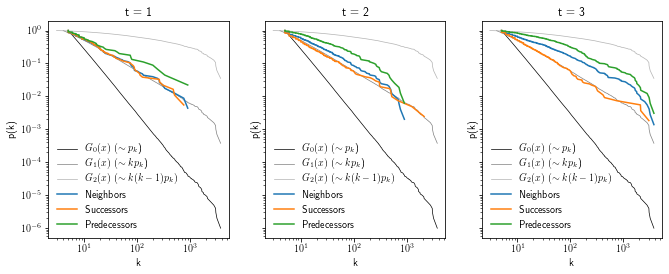

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(11,4), sharey=True)

for t, curr_ax in zip([1,2,3], axes):

    p_s = 0.01
    infected = [x for x in utils.nodes_with_given_state_at_time(t, "I", sim_data, G.nodes()) 
                    if x in T and list(T.predecessors(x))]
    infected_sampled = infected[:int(len(infected)*p_s)]


    successors = []
    predecessors = []
    neighbors = []
    for i in range(1000):
        node = np.random.choice(infected)
        try:
            neighbors.append(np.random.choice(list(T.successors(node)) + list(T.predecessors(node)))) 
        except ValueError:
            continue

        try:
            successors.append(np.random.choice(list(T.successors(node)))) 
        except ValueError:
            continue

        try:
            predecessors.append(np.random.choice(list(T.predecessors(node))))
        except ValueError:
            continue

    neighbors_ccdf = utils.ccdf_from_data(list(dict(G.degree(neighbors)).values()))
    successors_ccdf = utils.ccdf_from_data(list(dict(G.degree(successors)).values()))
    predecessors_ccdf = utils.ccdf_from_data(list(dict(G.degree(predecessors)).values()))

    utils.loglog_plot(ccdfs + [neighbors_ccdf, successors_ccdf, predecessors_ccdf], 
                      kwargs_list=plot_kwargs_for_base_ccdfs + [
                          {'label': "Neighbors"}, 
                          {'label': "Successors"},
                          {'label': "Predecessors"}
                      ], ax=curr_ax)
    curr_ax.set_title(f"t = {t}")